In [27]:
import numpy as np
import json
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
from datetime import datetime
from datetime import timedelta
import firebase_admin
from firebase_admin import db
from firebase_admin import credentials
import pytz


# Import from Firebase

To download data from firebase, you must have a unique key stored locally. The key will not be available from github and should not be uploaded to github. The following code currently downloads all the data from Firebase, as our database grows, future versions should look into only downloading the latest data.

In [2]:
### ONLY RUN ONCE! ###
#download data from firebase
try:
    firebase_admin.delete_app(app)
except:
    print('making new app')
cred = credentials.Certificate("../pc_basestation/fb_key.json")
app = firebase_admin.initialize_app(cred, {'databaseURL': 'https://haucs-monitoring-default-rtdb.firebaseio.com'})


making new app


In [4]:
## ONLY RUN TO REFRESH DATA! ###
ref = db.reference('/')
data = ref.get()

### RUN TO SAVE JSON FILE LOCALLY ###
with open('latest_data.json', 'w') as f:
    json.dump(data, f)

## Date Time
Firebase stores the time of data entries as a local datetime string. Due to daylight savings issues, we have to be careful with how to process datetime objects. The following code block handles converting local datetime objects into timezone aware datetime objects.

For data analysis, the date time objects should probably be converted into timestamps.

In [5]:
def to_datetime(dates, tz_aware=True):
    dt = []
    for i in dates:
        i = i.replace('T','_')
        i = i.replace('-','')
        i = i.replace(' ', '_')
        try:
            i_dt = datetime.strptime(i, '%Y%m%d_%H:%M:%S')
        except:
            print(i)
        if tz_aware:
            tz = pytz.timezone('US/Eastern')
            i_dt = tz.localize(i_dt)

        dt.append(i_dt)
    return np.array(dt)


# Local Data

Harvest results and sensor anomalies are recorded locally. The sensor log file keeps track of any anomalies that occur with the sensor.

| Event | Description | Value |
| - | - | - |
| i | installed in a tank | tank installed in |
| r | removed from a tank | tank removed from |
| c | debris cleaned from sensor | N/A |
| f | sensor failure leading to missing data | N/A |


In [6]:
## information regarding sensor installments/removals
## ID - biomass sensor (not algae tank)
df_anomaly = pd.read_csv('sensor_log.csv')
df_anomaly['datetime'] = to_datetime(df_anomaly.Date)

## information regarding algae harvests
## Before - algae (kg) in tank before harvest
## After  - algae (kg) in tank after harvest
## ID - algae tank
df_harvest = pd.read_csv('harvest_data.csv')
df_harvest['datetime'] = to_datetime(df_harvest.date)

# Processing Sensor Data

In [7]:
def moving_average(x, n=4):
    '''
    Simple moving average filter
    '''
    filter = np.ones(n) / n
    return np.convolve(x, filter, 'same')

class bmass_sensor():

    def __init__(self, name, data):
        self.d_dt = to_datetime(data[name]['data'])
        self.s_dt = to_datetime(data[name]['status'])
        self.on = np.array([int(data[name]['data'][i][1]) for i in data[name]['data']])
        self.off = np.array([int(data[name]['data'][i][0]) for i in data[name]['data']])
        self.g = np.array([int(data[name]['data'][i][2]) for i in data[name]['data']])
        self.battv = np.array([float(data[name]['status'][i]['batt_v']) for i in data[name]['status']])
        self.id = int(name[-1])


bm1 = bmass_sensor('bmass_1', data)
bm2 = bmass_sensor('bmass_2', data)
bm3 = bmass_sensor('bmass_3', data)
bm4 = bmass_sensor('bmass_4', data)
bm5 = bmass_sensor('bmass_5', data)

In [8]:
print("bm1: ", bm1.d_dt[-1], " ", bm1.on[-1], " ", bm1.off[-1], " ", bm1.g[-1])
print("bm2: ", bm2.d_dt[-1], " ", bm2.on[-1], " ", bm2.off[-1], " ", bm2.g[-1])
print("bm3: ", bm3.d_dt[-1], " ", bm3.on[-1], " ", bm3.off[-1], " ", bm3.g[-1])
print("bm4: ", bm4.d_dt[-1], " ", bm4.on[-1], " ", bm4.off[-1], " ", bm4.g[-1])
print("bm5: ", bm5.d_dt[-1], " ", bm5.on[-1], " ", bm5.off[-1], " ", bm5.g[-1])

bm1:  2023-07-31 17:51:18-04:00   129   1   1148
bm2:  2023-07-28 10:42:40-04:00   39   7   992
bm3:  2023-07-27 08:03:16-04:00   72   1   2228
bm4:  2023-07-31 17:49:14-04:00   124   1   2052
bm5:  2023-07-31 18:10:03-04:00   39   1   749


In [9]:
print(datetime.now())

2023-07-31 18:11:10.538540


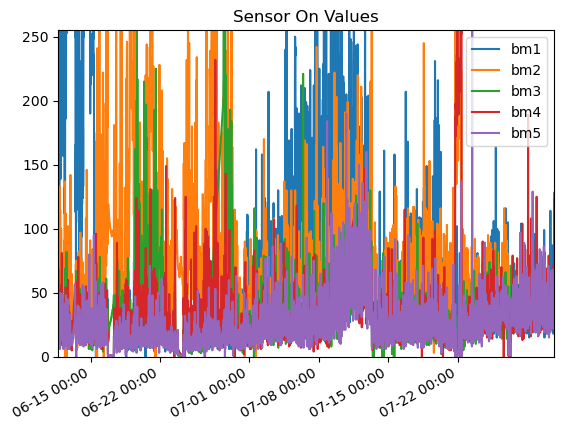

In [26]:
# Set date format for x-axis labels
date_fmt = '%m-%d %H:%M'
# Use DateFormatter to set the data to the correct format.
date_formatter = mdates.DateFormatter(date_fmt, tz=(pytz.timezone("US/Eastern")))



# upper = datetime(2023, 6, 25, hour=20, minute=0)
upper = datetime.now()
lower = upper - timedelta(days=50)
upper = pytz.timezone("US/Eastern").localize(upper)
lower = pytz.timezone("US/Eastern").localize(lower)
#plot
# plt.figure(figsize=(10,5))
plt.figure()
x = [bm1, bm2, bm3, bm4, bm5]

for i in x:
    plt.plot(i.d_dt, moving_average(i.on - i.off, 1))
plt.xlim(lower, upper)
plt.ylim(0, 255)
# plt.hlines(25, 0, 1e6, colors='salmon', linewidth=3)
plt.title("Sensor On Values")
plt.legend(['bm1','bm2', 'bm3', 'bm4', 'bm5'], loc='upper right')
plt.gcf().autofmt_xdate()
plt.gca().xaxis.set_major_formatter(date_formatter)
plt.show()

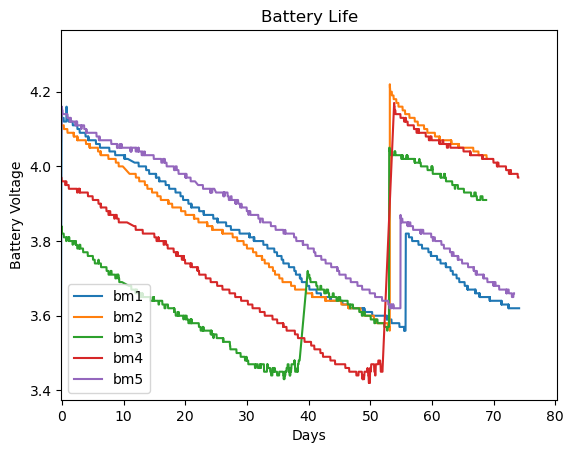

In [11]:
bm1_t = mdates.date2num(bm1.s_dt)
bm2_t = mdates.date2num(bm2.s_dt)
bm3_t = mdates.date2num(bm3.s_dt)
bm4_t = mdates.date2num(bm4.s_dt)
bm5_t = mdates.date2num(bm5.s_dt)

bm1_start = bm1_t[6285]
bm2_start = bm2_t[5155]
bm3_start = bm3_t[4840]
bm4_start = bm4_t[4880]
bm5_start = bm5_t[5058]


bm1_t = bm1_t - bm1_start
bm2_t = bm2_t - bm2_start
bm3_t = bm3_t - bm3_start
bm4_t = bm4_t - bm4_start
bm5_t = bm5_t - bm5_start

plt.figure()
plt.plot(bm1_t, bm1.battv)
plt.plot(bm2_t, bm2.battv)
plt.plot(bm3_t, bm3.battv)
plt.plot(bm4_t, bm4.battv)
plt.plot(bm5_t, bm5.battv)
plt.xlim(left=-.1)
plt.title("Battery Life")
plt.ylabel("Battery Voltage")
plt.xlabel("Days")
plt.legend(["bm1", "bm2", "bm3", "bm4", "bm5"], loc='lower left')
# plt.savefig("bm5_battery_life.png")
plt.show()

In [12]:
def days_remaining(start, bt, bv):
    slope, offset = np.polyfit(bt[start:], bv[start:], 1)
    init_v = bv[start]
    final_v = init_v - 1
    return int(-(bv[-1] - final_v)/slope)

print("battery 1: ", days_remaining(6285, bm1_t, bm1.battv))
print("battery 2: ", days_remaining(5155, bm2_t, bm2.battv))
print("battery 3: ", days_remaining(4840, bm3_t, bm3.battv))
print("battery 4: ", days_remaining(4880, bm4_t, bm4.battv))
print("battery 5: ", days_remaining(5058, bm5_t, bm5.battv))

battery 1:  74
battery 2:  1513
battery 3:  -270
battery 4:  -475
battery 5:  81


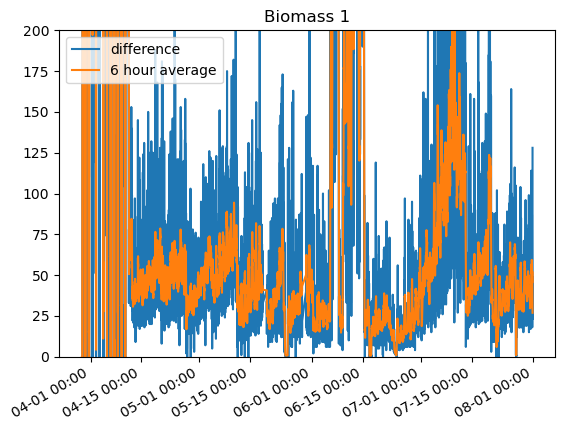

In [13]:
id = 1
bmx = bm1
lower = datetime(2023, 4, 25, hour=18)
lower = pytz.timezone("US/Eastern").localize(lower)
upper = datetime(2023, 4, 27, hour=5)
upper = pytz.timezone("US/Eastern").localize(upper)
#plot
plt.figure()
plt.plot(bmx.d_dt, moving_average((bmx.on - bmx.off),1))
plt.plot(bmx.d_dt, moving_average((bmx.on - bmx.off),12))


plt.ylim([0, 200])
plt.title("Biomass " + str(id))
plt.legend(['difference', '6 hour average'])
plt.gcf().autofmt_xdate()
plt.gca().xaxis.set_major_formatter(date_formatter)

#plot anomalies 
# bmx_anomalies = df_anomaly.index[df_anomaly.ID == id]
# print(bmx_anomalies)
# for i in bmx_anomalies:
#     print(df_anomaly.Event[i])
#     text = str(df_anomaly.Event[i])
#     pos = df_anomaly.datetime[i]
#     if (pos >= lower):
#         plt.text(pos, 50, text,
#                     bbox=dict(boxstyle="round,pad=0.3", ec='none', fc='lightblue'))
# plt.xlim([lower, upper])
# plt.show()


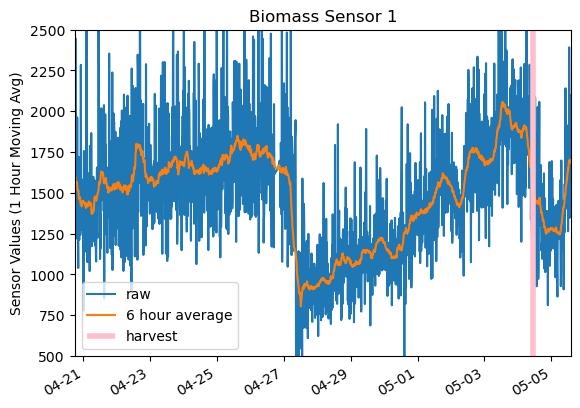

In [14]:
id = 1
bmx = bm1
lower = datetime(2023, 4, 20, hour=18)
lower = pytz.timezone("US/Eastern").localize(lower)
upper = datetime(2023, 5, 5, hour=14)
upper = pytz.timezone("US/Eastern").localize(upper)
hvest = datetime(2023,5,4,hour=11)
hvest = pytz.timezone("US/Eastern").localize(hvest)

# Set date format for x-axis labels
date_fmt = '%m-%d'
# Use DateFormatter to set the data to the correct format.
date_formatter = mdates.DateFormatter(date_fmt, tz=(pytz.timezone("US/Eastern")))

#plot
plt.figure()
# plt.plot(bmx.d_dt, moving_average(bmx.on, 6))
# plt.plot(bmx.d_dt, moving_average(bmx.off, 6))
# plt.plot(bmx.d_dt, moving_average((bmx.on - bmx.off),1))
# plt.plot(bmx.d_dt, moving_average((bmx.on - bmx.off),36))
plt.plot(bmx.d_dt, moving_average((bmx.g),1))
plt.plot(bmx.d_dt, moving_average((bmx.g),36))
plt.vlines(hvest, -10, 2500, color='pink', linewidth=4)


plt.ylim([500, 2500])
# plt.ylim([-10, 600])
plt.title("Biomass Sensor " + str(id))
# plt.ylabel("Sensor Values")
plt.ylabel("Sensor Values (1 Hour Moving Avg)")
plt.legend(['raw', '6 hour average', 'harvest'])
# plt.legend(['laser on', 'laser off', 'harvest'])
plt.gcf().autofmt_xdate()
plt.gca().xaxis.set_major_formatter(date_formatter)

# #plot anomalies 
# bmx_anomalies = df_anomaly.index[df_anomaly.ID == id]
# print(bmx_anomalies)
# for i in bmx_anomalies:
#     print(df_anomaly.Event[i])
#     text = str(df_anomaly.Event[i])
#     pos = df_anomaly.datetime[i]
#     if (pos >= lower):
#         plt.text(pos, 1000, text,
#                     bbox=dict(boxstyle="round,pad=0.3", ec='none', fc='lightblue'))
plt.xlim([lower, upper])
plt.savefig("bm1_harvest_golay.png")
plt.show()

In [15]:
g_dt = np.array(bm1.d_dt)

g_range = (g_dt >= lower) & (g_dt <= upper)

g = bm1.g[g_range]

Text(0, 0.5, 'Normalized Data')

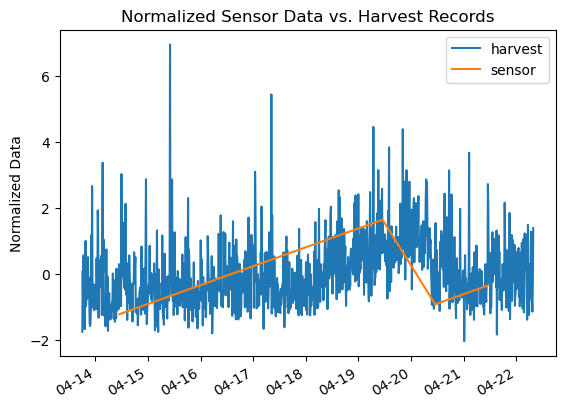

In [16]:
lower = datetime(2023, 4, 13, hour=18)
lower = pytz.timezone("US/Eastern").localize(lower)
upper = datetime(2023, 4, 22, hour=8)
upper = pytz.timezone("US/Eastern").localize(upper)

avg_span = 1

h_dt = df_harvest[(df_harvest.datetime >= lower) & (df_harvest.datetime <= upper)].datetime
h = df_harvest[(df_harvest.datetime >= lower) & (df_harvest.datetime <= upper)].tank2


g_dt = np.array(bm1.d_dt)
g_range = (g_dt >= lower) & (g_dt <= upper)
g_dt = g_dt[g_range]
g = bm1.g[g_range]

g = g / g.std()
g = g - g.mean()

h = h / h.std()
h = h - h.mean()

plt.figure()
plt.title("Normalized Sensor Data vs. Harvest Records")

plt.plot(g_dt[: -1 * avg_span], moving_average(g, avg_span)[: -1 * avg_span])
plt.plot(h_dt, h)
# plt.xlim(lower, upper)
plt.gcf().autofmt_xdate()
plt.gca().xaxis.set_major_formatter(date_formatter)
plt.legend(["harvest", "sensor"])
plt.ylabel("Normalized Data")

(19460.916666666668, 19474.5)

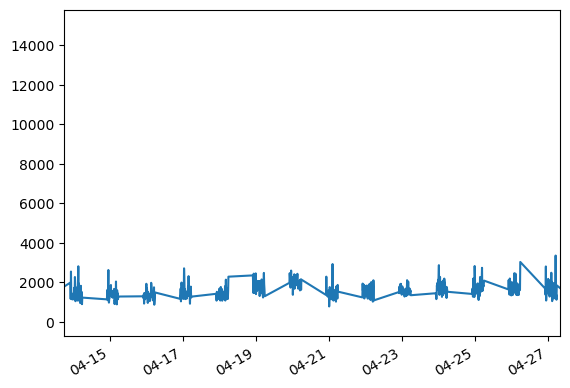

In [17]:

dt = np.array(bm1.d_dt)
n_dt = np.array([i for i in dt if i.hour < 6 or i.hour > 21])
n_mask = np.isin(dt, n_dt)
n_g = bm1.g[n_mask]

lower = datetime(2023, 4, 13, hour=18)
lower = pytz.timezone("US/Eastern").localize(lower)
upper = datetime(2023, 4, 27, hour=8)
upper = pytz.timezone("US/Eastern").localize(upper)

plt.figure();
plt.plot(n_dt, n_g);
plt.gcf().autofmt_xdate()
plt.gca().xaxis.set_major_formatter(date_formatter)
plt.xlim(lower, upper)


In [18]:
d_dt = np.array(bm2.d_dt)

harvest_values = []
g_values = []
diff_values = []
sensor_ids = []

sensors = [bm1, bm2, bm3, bm4, bm5]


start = datetime(2023, 5, 18, hour=10)
start  = pytz.timezone("US/Eastern").localize(start)


for bmx in sensors:

    d_dt = np.array(bmx.d_dt)
    d_mask = np.array([i > start for i in d_dt])
    only_night = np.array([(i.hour < 6) or (i.hour > 21) for i in d_dt])

    d_dt = d_dt[d_mask & only_night]
    on = bmx.on[d_mask & only_night]
    off = bmx.off[d_mask & only_night]
    g = bmx.g[d_mask & only_night]

    # g = g / g.std()
    # g = g - g.mean()
    # on = on / on.std()
    # on = on - on.mean()


    for i in df_harvest.index:

        meas_mass = df_harvest.loc[i].tank3
        dt = df_harvest.loc[i].datetime
        lower = timedelta(hours = 11)
        upper = timedelta(hours = 16)

        n_dt = np.array([i for i in d_dt if (i >= dt + lower) and (i <= dt + upper)])
        
        n_mask = np.isin(d_dt, n_dt)
        n_g = g[n_mask]
        n_diff = on[n_mask] - off[n_mask]
        
        if np.count_nonzero(n_mask) > 0:
            if meas_mass > 0:
                harvest_values.append(meas_mass)
                g_values.append(n_g.mean())
                diff_values.append(n_diff.mean())
                sensor_ids.append(bmx.id)


39.6


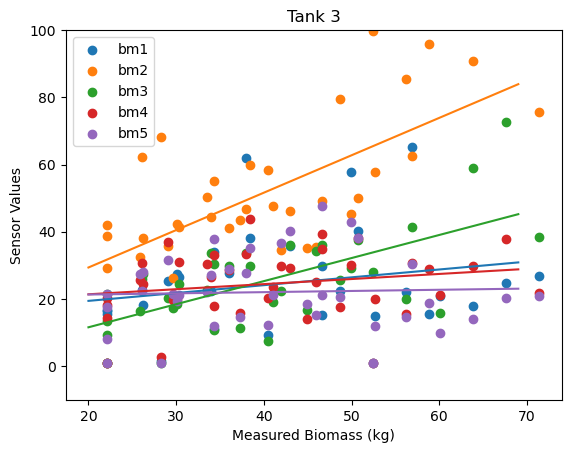

In [19]:
h = np.array(harvest_values)
g = np.array(g_values)
s = np.array(sensor_ids)
d = np.array(diff_values)

print(len(h) / 5)
plt.figure()
x = np.arange(20, 70)

for i in range(1, 6):
    h_i = h[(s == i) & (d < 100)]
    d_i = d[(s == i) & (d < 100)]
    step, offset = np.polyfit(h_i, d_i, 1)
    y = x * step + offset
    plt.scatter(h_i, d_i, label='bm' + str(i))
    plt.plot(x, y, label='_nolegend_')

plt.legend()
plt.ylim(-10, 100)
plt.title("Tank 3")
plt.xlabel("Measured Biomass (kg)")
plt.ylabel("Sensor Values")
plt.savefig("bmass_tank3.png")
plt.show()

# Deleting Data from Firebase

**WARNING**: this action will permanently alter the data in Firebase.

In [20]:
#select sensor and data or status path
del_path = '/bmass_5/data'
# del_path = '/LH_Farm'
del_node = db.reference(del_path)
#select start date for delete 
del_start = datetime(2023, 6, 23, hour=8, minute=15)
#select end date for delete
del_end = datetime(2023, 6, 23, hour=20, minute=0)

del_data = del_node.get()
del_data_dt = []
print("Deleting the Following Nodes: ", del_path)
for i in del_data:
    i_dt = datetime.fromisoformat(i)
    if (del_start <= i_dt <= del_end):
        print(i)
        del_data_dt.append(i)
        
#uncomment the following section to delete
print("Should these nodes be deleted? (y/n)")
# if (input('permanently delete (y/n): ') == 'y'):
#     for i in del_data_dt:
#         del_point = del_path + '/' + i
#         del_point = db.reference(del_point)
#         del_point.delete()

Deleting the Following Nodes:  /bmass_5/data
20230623_08:28:18
20230623_08:52:05
20230623_09:15:49
20230623_09:39:47
20230623_10:03:56
20230623_10:28:02
20230623_10:51:50
20230623_11:40:07
20230623_12:03:36
20230623_12:27:33
20230623_12:51:46
20230623_13:15:40
20230623_13:39:38
20230623_14:27:04
20230623_14:50:56
20230623_15:39:08
20230623_16:02:43
20230623_16:26:52
20230623_16:50:42
20230623_17:14:07
20230623_17:36:58
20230623_17:59:48
20230623_18:22:38
20230623_18:45:27
20230623_19:08:15
20230623_19:31:02
20230623_19:53:57
Should these nodes be deleted? (y/n)
